In [1]:
import os
import sys
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple

import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader


data_dir = Path("measurements")
print(f"Data resides in: {data_dir.resolve()}")

Data resides in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_consolidate/xxz_square_4x4/measurements


In [2]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden

        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)

        N, H = self.num_visible, self.num_hidden
        return torch.split(x, [N, N, H, H], dim=-1)


class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.cond_dim = cond_dim
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))

        self.initialize_weights(w_std=0.1)

        self.conditioner = Conditioner(num_visible=num_visible, num_hidden=num_hidden,
                                       cond_dim=cond_dim, hidden_width=conditioner_width)

    def initialize_weights(self, w_mean: float = 0.0, w_std: float = 0.1, bias_val: float = 0.0):
        nn.init.normal_(self.W, mean=w_mean, std=w_std)
        nn.init.constant_(self.b, bias_val)
        nn.init.constant_(self.c, bias_val)

    @staticmethod
    def _free_energy(v: torch.Tensor, W: torch.Tensor, b: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        v = v.to(dtype=W.dtype, device=W.device)    # v can come in dtype int or bool

        # broadcasting handles (Batch, N) * (1, N) automatically
        term1 = -(v * b).sum(dim=-1)
        term2 = F.softplus(v @ W + c).sum(dim=-1)
        return term1 - term2

    def _compute_effective_biases(self, cond: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)

        # explicit unsqueeze(0) ensures we broadcast correctly against the batch dimension
        b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
        c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, T: float, rng: torch.Generator):
        p_h = torch.sigmoid((v @ self.W + c_mod) / T)
        h = torch.bernoulli(p_h, generator=rng)

        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / T)
        v_next = torch.bernoulli(p_v, generator=rng)
        return v_next

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        fe = self._free_energy(v, self.W, b_mod, c_mod)
        return -0.5 * fe / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        values, _, cond = batch
        v_data = values.to(dtype=self.W.dtype, device=self.W.device)

        # if no rng in our aux_vars, we create a new one on CPU (not ideal, but safe)
        rng = aux_vars.get("rng", torch.Generator(device="cpu"))
        l2_strength = float(aux_vars.get("l2_strength", 0.0))

        # condition biases and regularize large deviations from base biases
        cond = cond.to(v_data.device, dtype=v_data.dtype)
        b_mod, c_mod = self._compute_effective_biases(cond)
        l2_reg = (self.b.unsqueeze(0) - b_mod).pow(2).sum() + (self.c.unsqueeze(0) - c_mod).pow(2).sum()

        # run negative phase as CD-k initialized from random noise. detach gradient from chain.
        v_model = torch.bernoulli(torch.full_like(v_data, 0.5), generator=rng)

        for _ in range(self.k):
            v_model = self._gibbs_step(v_model, b_mod, c_mod, self.T, rng)

        v_model = v_model.detach()

        # compose loss from free energy difference and regularization
        fe_data = self._free_energy(v_data, self.W, b_mod, c_mod)
        fe_model = self._free_energy(v_model, self.W, b_mod, c_mod)
        fe_diff = fe_data - fe_model

        loss = fe_diff.mean() + l2_strength * l2_reg

        fe_mean = fe_diff.mean().detach()
        fe_std = fe_diff.std(unbiased=False).detach()

        return loss, { "free_energy_mean": fe_mean, "free_energy_std": fe_std }

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, T_schedule: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        B = cond.shape[0]

        # allow to pass a 1D condition and a scalar temperature schedule
        if cond.dim() == 1:
            cond = cond.view(-1, self.cond_dim)

        if T_schedule.dim() == 0:
            T_schedule = T_schedule.view(1)

        cond = cond.to(next(self.parameters()).device, dtype=torch.float32)

        b_mod, c_mod = self._compute_effective_biases(cond)

        # for new samples we initialize from uniform noise
        probs = torch.full((B, self.num_visible), 0.5, device=cond.device, dtype=torch.float32)
        v = torch.bernoulli(probs, generator=rng)

        for i in range(int(T_schedule.shape[0])):
            v = self._gibbs_step(v, b_mod, c_mod, float(T_schedule[i]), rng)

        return v

In [3]:
# OBSERVABLES (FOR EVALUATION)

def compute_czz(samples: torch.Tensor, pairs: List[Tuple[int, int]]) -> Tuple[float, float]:
    # casting only to ensure proper float dtype for mean/std calculations
    spins_pm = 1.0 - 2.0 * samples.to(dtype=torch.float32)

    # here we demonstrate vectorization over pairs
    idx_u = torch.tensor([p[0] for p in pairs], device=samples.device)
    idx_v = torch.tensor([p[1] for p in pairs], device=samples.device)
    spin_parities = spins_pm[:, idx_u] * spins_pm[:, idx_v]

    sample_czz = spin_parities.mean(dim=1)

    total_czz = sample_czz.mean().item()
    total_czz_err = sample_czz.std(unbiased=True).item() / math.sqrt(samples.shape[0])

    return total_czz, total_czz_err


def compute_cxx(samples: torch.Tensor, pairs: List[Tuple[int, int]],
                log_score_fn: Callable[[torch.Tensor], torch.Tensor]) -> Tuple[float, float]:

    B = samples.shape[0]

    # samples can remain in the original dtype since mean and std come from ratios. scroing function handles casting.

    with torch.no_grad():
        log_scores_orig = log_score_fn(samples)

        sample_cxx = torch.zeros(B, device=samples.device, dtype=torch.float32)
        for u, v in pairs:
            flipped_samples = samples.clone()
            flipped_samples[:, u] = 1 - flipped_samples[:, u]
            flipped_samples[:, v] = 1 - flipped_samples[:, v]

            log_scores_flip = log_score_fn(flipped_samples)

            log_ratios = log_scores_flip - log_scores_orig
            ratios = torch.exp(log_ratios)

            sample_cxx += ratios

        sample_cxx /= len(pairs)

        total_cxx = sample_cxx.mean().item()
        total_cxx_err = sample_cxx.std(unbiased=True).item() / math.sqrt(B)

        return total_cxx, total_cxx_err


# === MONITORING LOGIC ===
# Cxx measures the off-diagonal fluctuations. It effectively calculates exp(-(E_flipped - E_data)).
# 1. High Start: Weights are small, landscape is flat (E_flipped approx E_data). Ratio is near 1.0.
#    The model allows free fluctuations.
# 2. Sharp Drop: Model learns classical order. It digs deep valleys for data (low E_data) and penalizes
#    deviations (high E_flipped). The "Vertical Distance" becomes huge. Ratio drops near 0.0.
# 3. Stabilization: Model learns quantum superposition. It lowers the energy cost of specific spin flips,
#    reducing the vertical distance to the physically correct gap.

# it is important to perform monitoring on a fixed choice of samples. we wanna see this value stabilize over epochs.
def monitor_cxx(model, ds, pair_indices, device, seed: int):
    model.eval()

    rng = torch.Generator()
    rng.manual_seed(seed)

    num_samples = len(ds)
    n_monitor = min(1000, num_samples)
    indices = torch.randint(0, num_samples, (n_monitor,), generator=rng)

    samples = torch.as_tensor(ds.values[indices], device=device)
    cond = torch.as_tensor(ds.system_params[indices], device=device, dtype=torch.float32)

    scorer = lambda v: model.log_score(v, cond)

    cxx_val, _ = compute_cxx(samples, pair_indices, scorer)

    model.train()
    return cxx_val

In [4]:
def train_step(model: nn.Module, optimizer: torch.optim.Optimizer,
               batch: Tuple[torch.Tensor, List[Tuple[str, ...]], Optional[torch.Tensor]], aux_vars: Dict[str, Any]):
    optimizer.zero_grad(set_to_none=True)
    loss, aux = model(batch, aux_vars)
    loss.backward()
    optimizer.step()
    return loss.detach(), aux


def train(model: nn.Module, optimizer: torch.optim.Optimizer, loader, num_epochs: int, rng: torch.Generator,
          monitor_seed: int, l2_strength: float, lr_schedule_fn: Callable[[int], float],
          ds: MeasurementDataset, monitor_pairs: List[Tuple[int, int]]):

    metrics: Dict[int, Any] = {}
    global_step = 0
    device = next(model.parameters()).device

    print(f"{'Epoch':<8} | {'Loss':<9} | {'Free En STD':<10} | {'LR':<8} | {'Cxx':<9}")
    print("-" * 60)

    for epoch in range(num_epochs):
        tot_loss = 0.0
        fe_mean_last = torch.tensor(0.0)
        fe_std_last = torch.tensor(0.0)

        for batch in loader:
            lr = float(lr_schedule_fn(global_step))
            for g in optimizer.param_groups:
                g["lr"] = lr

            aux_vars = { "rng": rng, "l2_strength": l2_strength }
            loss, aux_out = train_step(model, optimizer, batch, aux_vars)

            tot_loss += float(loss)
            fe_mean_last = aux_out.get("free_energy_mean", torch.tensor(0.0))
            fe_std_last = aux_out.get("free_energy_std", torch.tensor(0.0))
            global_step += 1

        avg_loss = tot_loss / len(loader)
        lr_epoch = float(lr_schedule_fn(global_step))

        # the monitor must have a consistent seed across epochs
        cxx_curr = monitor_cxx(model, ds, monitor_pairs, device, seed=monitor_seed)

        metrics[epoch] = dict(loss=avg_loss, free_energy_mean=float(fe_mean_last),
                              free_energy_var=float(fe_std_last), lr=lr_epoch, cxx=cxx_curr)

        print(f"{epoch + 1:<8} | {avg_loss:+.4f}   | {float(fe_std_last):.4f}      | "
              f"{lr_epoch:.5f}  | {cxx_curr:+.5f}")

    return model, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2.0
    def curve_fn(step: int) -> float:
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center_step))))
    return curve_fn

In [5]:
# DATA LOADING

SIDE_LENGTH = 4
FILE_SAMPLES = 5_000_000
TRAIN_SAMPLES = 50_000  # beyond 100k per file it gets slow

# construct filenames dynamically based on support deltas
delta_support = [0.40, 0.60, 0.80, 0.90, 0.95, 1.00, 1.05, 1.10, 1.40, 2.00]
file_names = [f"xxz_{SIDE_LENGTH}x{SIDE_LENGTH}_delta{d:.2f}_{FILE_SAMPLES}.npz" for d in delta_support]
file_paths = [data_dir / fn for fn in file_names]
samples_per_file = [TRAIN_SAMPLES] * len(file_paths)

diag_indices = [k * (SIDE_LENGTH + 1) for k in range(SIDE_LENGTH)]
corr_pairs = list(zip(diag_indices, diag_indices[1:]))

print(f"System Size       : {SIDE_LENGTH}x{SIDE_LENGTH} ({SIDE_LENGTH**2} qubits)")
print(f"Training Samples  : {TRAIN_SAMPLES} per file (from {FILE_SAMPLES} total)")
print(f"Support Deltas    : {delta_support}")
print(f"Correlation Pairs : {corr_pairs} (main diagonal neighbors)")

ds = MeasurementDataset(file_paths, load_fn=load_measurements_npz,
                        system_param_keys=["delta"], samples_per_file=samples_per_file)

print(f"Samples Shape     : {tuple(ds.values.shape)}")
print(f"Conditions Shape  : {tuple(ds.system_params.shape)}")

System Size       : 4x4 (16 qubits)
Training Samples  : 50000 per file (from 5000000 total)
Support Deltas    : [0.4, 0.6, 0.8, 0.9, 0.95, 1.0, 1.05, 1.1, 1.4, 2.0]
Correlation Pairs : [(0, 5), (5, 10), (10, 15)] (main diagonal neighbors)
Samples Shape     : (500000, 16)
Conditions Shape  : (500000, 1)


In [ ]:
 # TRAINING

batch_size        = 1024
num_visible       = ds.num_qubits
num_hidden        = 32
conditioner_width = 64

num_epochs        = 10
k_steps           = 100
init_lr           = 1e-2
final_lr          = init_lr * 0.1
l2_strength       = 1e-4


SEED = 42
torch.manual_seed(SEED)
rng = torch.Generator().manual_seed(SEED)

loader = MeasurementLoader(dataset=ds, batch_size=batch_size, shuffle=True, drop_last=False, rng=rng)

model = ConditionalRBM(num_visible=num_visible, num_hidden=num_hidden, cond_dim=ds.system_params.shape[1],
                       conditioner_width=conditioner_width, k=k_steps, T=1.0)

# keep std big enough to ensure energy barriers (good mixing) at start but not so big that we cant navigate the landscape
model.initialize_weights(w_mean=0.0, w_std=0.1, bias_val=0.0)

optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005)

model, metrics = train(model=model, optimizer=optimizer, loader=loader, num_epochs=num_epochs,
                       rng=rng, monitor_seed=SEED, l2_strength=l2_strength,
                       lr_schedule_fn=lr_schedule_fn, ds=ds, monitor_pairs=corr_pairs)

Epoch    | Loss      | Free En STD | LR       | Cxx      
------------------------------------------------------------


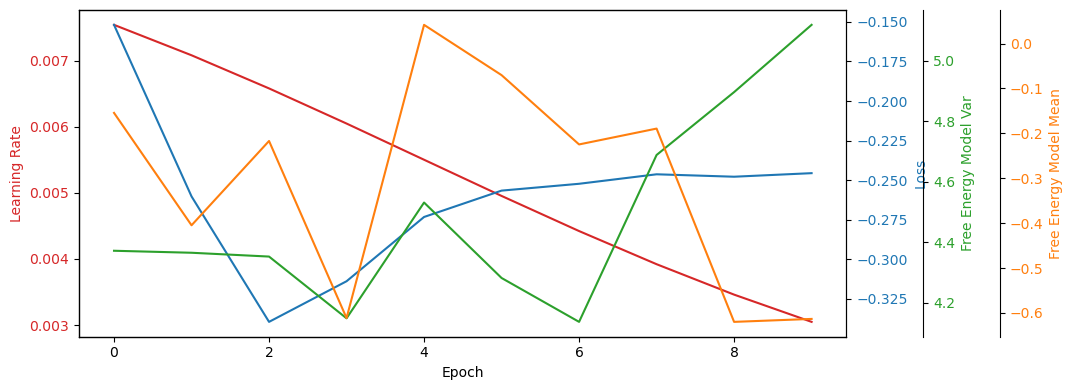

In [7]:
epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]
free_model_mean_vals = [metrics[e]['free_energy_mean'] for e in epochs]
free_model_var_vals = [metrics[e]['free_energy_var'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots(figsize=(11, 4))

ax1.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Learning Rate", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
ax2.spines["right"].set_position(("axes", 1.00))
ax2.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax2.set_ylabel("Loss", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
ax3.plot(epochs, free_model_var_vals, label="Free Energy Model Var", color="tab:green")
ax3.set_ylabel("Free Energy Model Var", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.2))
ax4.plot(epochs, free_model_mean_vals, label="Free Energy Model Mean", color="tab:orange")
ax4.set_ylabel("Free Energy Model Mean", color="tab:orange")
ax4.tick_params(axis="y", labelcolor="tab:orange")

plt.tight_layout()
plt.show()

In [8]:
# EVALUATION

# define novel points and combine with support points
delta_novel = [0.50, 0.70, 0.85, 1.20, 1.60, 1.80]

sweep = sorted([(d, "support") for d in delta_support] + [(d, "novel")   for d in delta_novel], key=lambda x: x[0])

T_eval = 1.0
eval_samples = 10_000

# separate RNG for evaluation to avoid overlap with training state
rng_eval = torch.Generator().manual_seed(1234)

print("=== EVALUATION SWEEP =========================================")
print(f"Evaluating on pairs: {corr_pairs}")
print(f"Total points: {len(sweep)} ({len(delta_support)} support, {len(delta_novel)} novel)")
print("==============================================================")

results = []

for delta, kind in sweep:
    # prepare batch of multiple samples with the same condition
    cond_single = torch.tensor([[delta]], device=next(model.parameters()).device, dtype=torch.float32)
    cond_batch = cond_single.expand(eval_samples, -1)

    # sample with temperature schedule (constant 1 instead of annealing here)
    T_schedule = torch.full((model.k,), T_eval, device=cond_batch.device)
    samples = model.generate(cond_batch, T_schedule, rng_eval)

    # score for this certain condition
    scorer = lambda v: model.log_score(v, cond_batch)
    czz, _ = compute_czz(samples, corr_pairs)
    cxx, _ = compute_cxx(samples, corr_pairs, scorer)

    results.append({"delta": delta, "type": kind, "czz_diag": czz, "cxx_diag": cxx})
    print(f"Delta {delta:5.2f} [{kind:7}] | Czz: {czz:+.5f} | Cxx: {cxx:+.5f}")

df = pd.DataFrame(results).sort_values("delta")

=== EVALUATION SWEEP =========================================
Evaluating on pairs: [(0, 5), (5, 10), (10, 15)]
Total points: 16 (10 support, 6 novel)
Delta  0.40 [support] | Czz: +0.36220 | Cxx: +0.33793
Delta  0.50 [novel  ] | Czz: +0.35553 | Cxx: +0.34837
Delta  0.60 [support] | Czz: +0.37453 | Cxx: +0.32948
Delta  0.70 [novel  ] | Czz: +0.36827 | Cxx: +0.32969
Delta  0.80 [support] | Czz: +0.36893 | Cxx: +0.33620
Delta  0.85 [novel  ] | Czz: +0.36533 | Cxx: +0.33861
Delta  0.90 [support] | Czz: +0.36373 | Cxx: +0.32282
Delta  0.95 [support] | Czz: +0.37540 | Cxx: +0.32462
Delta  1.00 [support] | Czz: +0.37080 | Cxx: +0.33653
Delta  1.05 [support] | Czz: +0.37387 | Cxx: +0.33380
Delta  1.10 [support] | Czz: +0.36933 | Cxx: +0.33898
Delta  1.20 [novel  ] | Czz: +0.37113 | Cxx: +0.32637
Delta  1.40 [support] | Czz: +0.36993 | Cxx: +0.33947
Delta  1.60 [novel  ] | Czz: +0.36740 | Cxx: +0.33628
Delta  1.80 [novel  ] | Czz: +0.36233 | Cxx: +0.34846
Delta  2.00 [support] | Czz: +0.37200 |

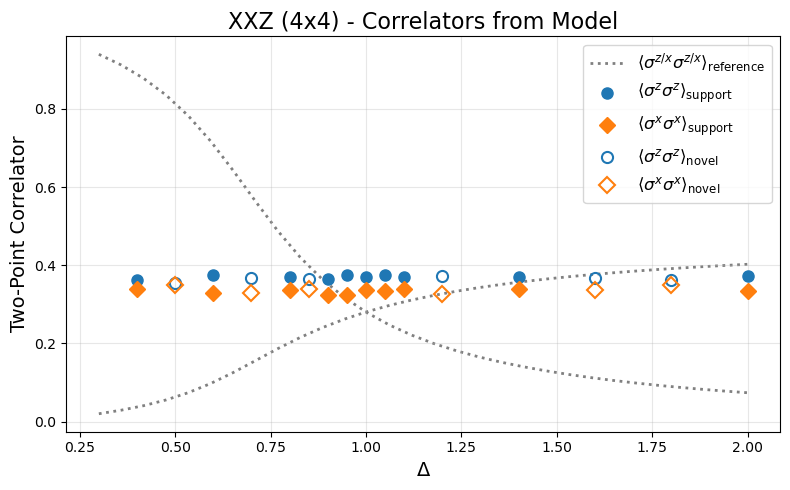

In [9]:
ref_file = Path(f"xxz_{SIDE_LENGTH}x{SIDE_LENGTH}_correlations_ref.csv")
ref_df = pd.read_csv(ref_file) if ref_file.exists() else None

supp = df[df["type"] == "support"]
nov = df[df["type"] == "novel"]

plt.figure(figsize=(8, 5))

if ref_df is not None:
    plt.plot(ref_df["delta"], ref_df["czz_diag"], ':', color='gray', linewidth=2.0, label='_nolegend_', zorder=1)
    plt.plot(ref_df["delta"], ref_df["cxx_diag"], ':', color='gray', linewidth=2.0,
             label=r'$\langle \sigma^{z/x} \sigma^{z/x} \rangle_{\mathrm{reference}}$', zorder=1)

plt.plot(supp["delta"], supp["czz_diag"], 'o', color='C0', markersize=8,
         label=r'$\langle \sigma^z \sigma^z \rangle_{\mathrm{support}}$', zorder=2)
plt.plot(supp["delta"], supp["cxx_diag"], 'D', color='C1', markersize=8,
         label=r'$\langle \sigma^x \sigma^x \rangle_{\mathrm{support}}$', zorder=2)

plt.plot(nov["delta"], nov["czz_diag"], 'o', color='C0', markerfacecolor='none',
         markersize=8, markeredgewidth=1.5, label=r'$\langle \sigma^z \sigma^z \rangle_{\mathrm{novel}}$', zorder=2)
plt.plot(nov["delta"], nov["cxx_diag"], 'D', color='C1', markerfacecolor='none',
         markersize=8, markeredgewidth=1.5, label=r'$\langle \sigma^x \sigma^x \rangle_{\mathrm{novel}}$', zorder=2)

plt.xlabel(r'$\Delta$', fontsize=14)
plt.ylabel('Two-Point Correlator', fontsize=14)
plt.title(f"XXZ ({SIDE_LENGTH}x{SIDE_LENGTH}) - Correlators from Model", fontsize=16)

plt.legend(frameon=True, fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
file_name = f"xxz_{SIDE_LENGTH}x{SIDE_LENGTH}_correlations_rbm.csv"
df.to_csv(file_name, index=False, float_format="%.6f")
print(f"\nSaved RBM correlators to: {os.path.abspath(file_name)}")


Saved RBM correlators to: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_consolidate/xxz_square_4x4/xxz_4x4_correlations_rbm.csv
